In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Subset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

BATCH_SIZE=2
EPOCH=50
LEARNING_RATE=0.001

c:\Users\Zeynep Aygün\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Zeynep Aygün\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


cuda:0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
import random
min_class_limit=2721
# Maximum number of samples in the train set
train_limit = None
# Maximum number of samples in the val set
val_limit = None

# Create the original datasets and dataloaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
      
    ]),
    'val': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
   
    ])
}

data_dir = 'C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/data/BIRADS_split'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# Find the number of classes
num_classes = len(train_dataset.classes)
class_names=train_dataset.classes

# Select 5000 images from each class
selected_indices = []
for i in range(num_classes):
    class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
    class_indices = random.sample(class_indices, min(len(class_indices), min_class_limit))
    selected_indices.extend(class_indices)

# Select the specified number of samples from the train set
if train_limit is not None:
    selected_indices = selected_indices[:train_limit]

# Create new Subsets using the selected indices
train_subset = Subset(train_dataset, selected_indices)
val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

# Create new DataLoaders for the Subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Update the dataset_sizes dictionary
dataset_sizes = {
        'train': len(train_subset),
        'val': len(val_subset)
    }
image_datasets = {
        'train': train_subset,
        'val': val_subset
    }
dataloaders={}
dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader

dataset_sizes

{'train': 8163, 'val': 5401}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   
    plt.figure(figsize=(3,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):
    min_class_limit=2721
    selected_indices = []
    for i in range(num_classes):
        class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
        class_indices = random.sample(class_indices, min(len(class_indices), min_class_limit))
        selected_indices.extend(class_indices)

    # Select the specified number of samples from the train set
    if train_limit is not None:
        selected_indices = selected_indices[:train_limit]

    # Create new Subsets using the selected indices
    train_subset = Subset(train_dataset, selected_indices)
    val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

    # Create new DataLoaders for the Subsets
    train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader
    
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                # Calculate and plot confusion matrix
                y_true = []
                y_pred = []

                model.eval()

                with torch.no_grad():
                    for inputs, labels in dataloaders['val']:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        y_true += labels.tolist()
                        y_pred += preds.tolist()

                cm = confusion_matrix(y_true, y_pred)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted labels')
                plt.ylabel('True labels')
                plt.title('Confusion matrix')
                plt.show()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [5]:
# A dictionary of models.

modeller={
    'BIRADS_EFFB1':models.efficientnet_b1(pretrained=True)
}
try:
    os.mkdir('./modelPerformance')
except:
    print('Dosyalar var')

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to C:\Users\Zeynep Aygün/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:02<00:00, 11.7MB/s]


Dosyalar var


In [8]:
models.efficientnet_b1(pretrained=True).classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [11]:
model_ft = models.efficientnet_b1(pretrained=True)

model_ft.classifier[1]=nn.Linear(in_features=1280, out_features=3, bias=True)
model_ft.classifier[0]=nn.Dropout(p=0.5, inplace=True)
model_ft

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Epoch 1/50
----------


100%|██████████| 4081/4081 [06:31<00:00, 10.41it/s]


train Loss: 1.0008 Acc: 0.4953


100%|██████████| 2700/2700 [01:23<00:00, 32.15it/s]


val Loss: 0.8385 Acc: 0.6725


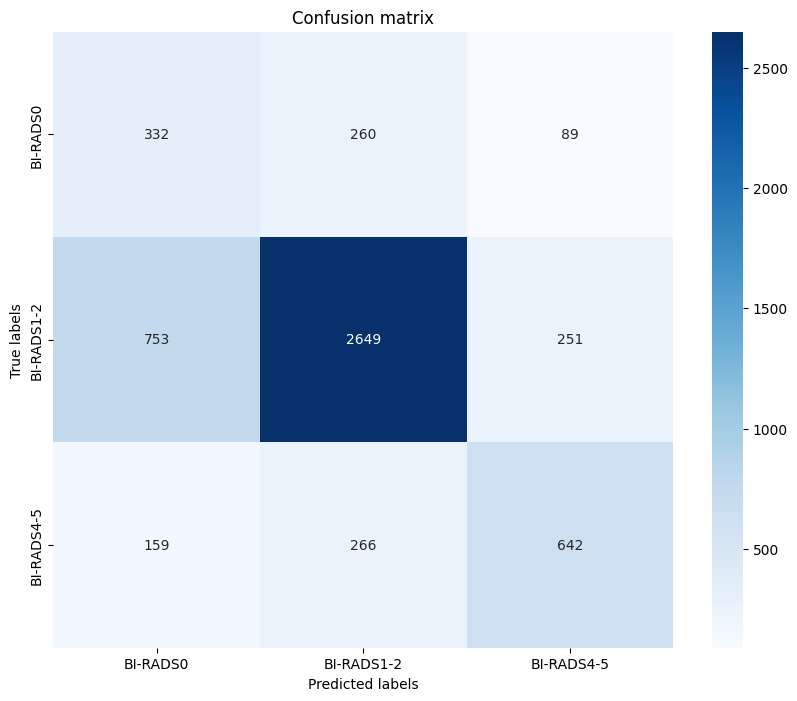


Epoch 2/50
----------


100%|██████████| 4081/4081 [07:14<00:00,  9.39it/s]


train Loss: 0.8687 Acc: 0.5927


100%|██████████| 2700/2700 [01:38<00:00, 27.39it/s]


val Loss: 0.8735 Acc: 0.6684

Epoch 3/50
----------


100%|██████████| 4081/4081 [06:23<00:00, 10.65it/s]


train Loss: 0.8505 Acc: 0.6084


100%|██████████| 2700/2700 [01:12<00:00, 37.30it/s]


val Loss: 0.7923 Acc: 0.7212


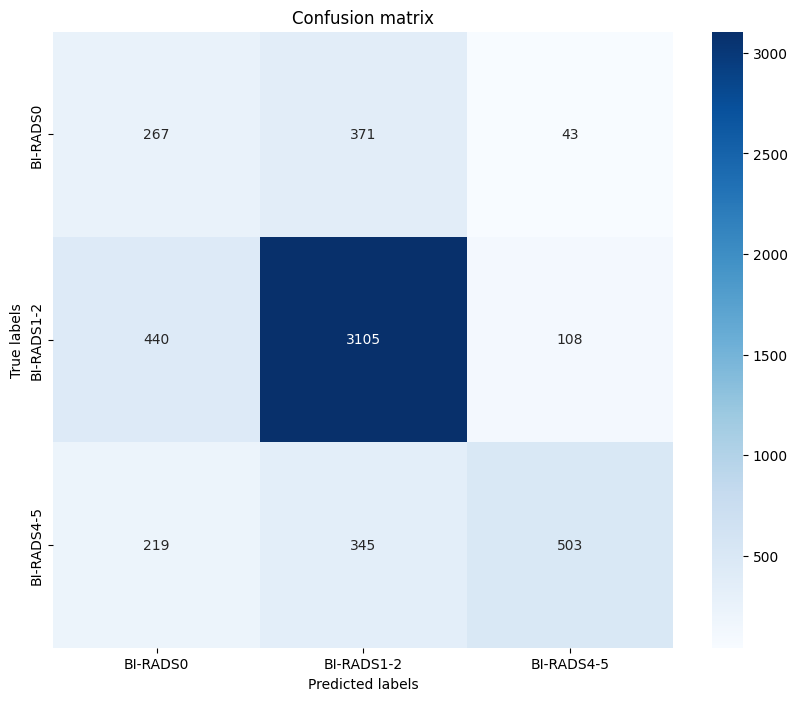


Epoch 4/50
----------


100%|██████████| 4081/4081 [06:07<00:00, 11.11it/s]


train Loss: 0.8508 Acc: 0.6095


100%|██████████| 2700/2700 [01:31<00:00, 29.57it/s]


val Loss: 0.7868 Acc: 0.7276


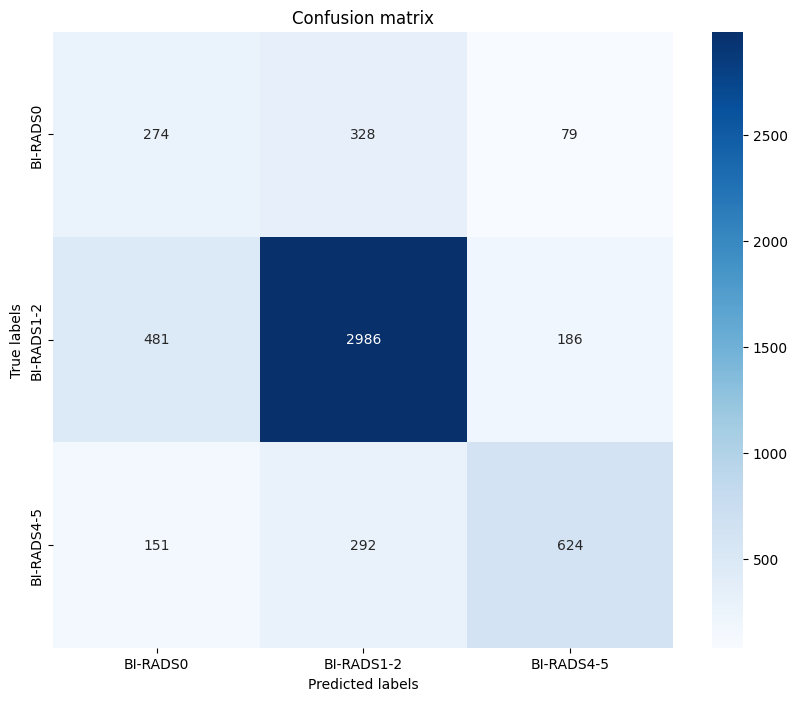


Epoch 5/50
----------


100%|██████████| 4081/4081 [05:58<00:00, 11.37it/s]


train Loss: 0.8591 Acc: 0.5987


100%|██████████| 2700/2700 [01:13<00:00, 36.94it/s]


val Loss: 0.8275 Acc: 0.6828

Epoch 6/50
----------


100%|██████████| 4081/4081 [06:07<00:00, 11.11it/s]


train Loss: 0.8208 Acc: 0.6275


100%|██████████| 2700/2700 [01:14<00:00, 36.40it/s]


val Loss: 0.8369 Acc: 0.6695

Epoch 7/50
----------


100%|██████████| 4081/4081 [05:56<00:00, 11.43it/s]


train Loss: 0.8203 Acc: 0.6223


100%|██████████| 2700/2700 [01:17<00:00, 34.66it/s]


val Loss: 0.8857 Acc: 0.6397

Epoch 8/50
----------


100%|██████████| 4081/4081 [05:32<00:00, 12.28it/s]


train Loss: 0.8160 Acc: 0.6261


100%|██████████| 2700/2700 [01:11<00:00, 37.51it/s]


val Loss: 0.8248 Acc: 0.6893

Epoch 9/50
----------


100%|██████████| 4081/4081 [06:02<00:00, 11.25it/s]


train Loss: 0.8244 Acc: 0.6238


100%|██████████| 2700/2700 [01:12<00:00, 37.31it/s]


val Loss: 0.8159 Acc: 0.6962

Epoch 10/50
----------


100%|██████████| 4081/4081 [06:00<00:00, 11.32it/s]


train Loss: 0.8232 Acc: 0.6178


100%|██████████| 2700/2700 [01:12<00:00, 37.00it/s]


val Loss: 0.8249 Acc: 0.6880

Epoch 11/50
----------


100%|██████████| 4081/4081 [05:54<00:00, 11.50it/s]


train Loss: 0.8168 Acc: 0.6244


100%|██████████| 2700/2700 [01:18<00:00, 34.39it/s]


val Loss: 0.8463 Acc: 0.6719

Epoch 12/50
----------


100%|██████████| 4081/4081 [05:34<00:00, 12.20it/s]


train Loss: 0.8269 Acc: 0.6158


100%|██████████| 2700/2700 [01:17<00:00, 34.85it/s]


val Loss: 0.7958 Acc: 0.7134

Epoch 13/50
----------


100%|██████████| 4081/4081 [05:53<00:00, 11.55it/s]


train Loss: 0.8234 Acc: 0.6220


100%|██████████| 2700/2700 [01:12<00:00, 37.41it/s]


val Loss: 0.8093 Acc: 0.6771

Epoch 14/50
----------


100%|██████████| 4081/4081 [06:02<00:00, 11.25it/s]


train Loss: 0.8163 Acc: 0.6297


100%|██████████| 2700/2700 [01:12<00:00, 37.21it/s]


val Loss: 0.7906 Acc: 0.7021

Epoch 15/50
----------


100%|██████████| 4081/4081 [06:24<00:00, 10.62it/s]


train Loss: 0.8189 Acc: 0.6226


100%|██████████| 2700/2700 [01:29<00:00, 30.19it/s]


val Loss: 0.8711 Acc: 0.6706

Epoch 16/50
----------


100%|██████████| 4081/4081 [06:02<00:00, 11.25it/s]


train Loss: 0.8190 Acc: 0.6281


100%|██████████| 2700/2700 [01:34<00:00, 28.51it/s]


val Loss: 0.8481 Acc: 0.6752

Epoch 17/50
----------


100%|██████████| 4081/4081 [06:08<00:00, 11.06it/s]


train Loss: 0.8190 Acc: 0.6246


100%|██████████| 2700/2700 [01:29<00:00, 30.31it/s]


val Loss: 0.8256 Acc: 0.6873

Epoch 18/50
----------


100%|██████████| 4081/4081 [06:07<00:00, 11.10it/s]


train Loss: 0.8083 Acc: 0.6325


100%|██████████| 2700/2700 [01:33<00:00, 28.98it/s]


val Loss: 0.7974 Acc: 0.7267

Epoch 19/50
----------


100%|██████████| 4081/4081 [06:01<00:00, 11.28it/s]


train Loss: 0.8169 Acc: 0.6250


100%|██████████| 2700/2700 [01:29<00:00, 30.18it/s]


val Loss: 0.8241 Acc: 0.7052

Epoch 20/50
----------


100%|██████████| 4081/4081 [06:15<00:00, 10.86it/s]


train Loss: 0.8241 Acc: 0.6229


100%|██████████| 2700/2700 [01:33<00:00, 28.93it/s]


val Loss: 0.9458 Acc: 0.6421

Epoch 21/50
----------


100%|██████████| 4081/4081 [05:58<00:00, 11.40it/s]


train Loss: 0.8222 Acc: 0.6235


100%|██████████| 2700/2700 [01:30<00:00, 29.96it/s]


val Loss: 0.8404 Acc: 0.6701

Epoch 22/50
----------


100%|██████████| 4081/4081 [05:59<00:00, 11.37it/s]


train Loss: 0.8150 Acc: 0.6330


100%|██████████| 2700/2700 [01:27<00:00, 30.80it/s]


val Loss: 0.8984 Acc: 0.6490

Epoch 23/50
----------


100%|██████████| 4081/4081 [05:59<00:00, 11.34it/s]


train Loss: 0.8210 Acc: 0.6282


100%|██████████| 2700/2700 [01:50<00:00, 24.41it/s]


val Loss: 0.8107 Acc: 0.7064

Epoch 24/50
----------


100%|██████████| 4081/4081 [06:42<00:00, 10.15it/s]


train Loss: 0.8239 Acc: 0.6272


100%|██████████| 2700/2700 [01:28<00:00, 30.58it/s]


val Loss: 0.8587 Acc: 0.6669

Epoch 25/50
----------


100%|██████████| 4081/4081 [06:05<00:00, 11.16it/s]


train Loss: 0.8207 Acc: 0.6179


100%|██████████| 2700/2700 [01:34<00:00, 28.48it/s]


val Loss: 0.8136 Acc: 0.6941

Epoch 26/50
----------


100%|██████████| 4081/4081 [06:06<00:00, 11.14it/s]


train Loss: 0.8272 Acc: 0.6160


100%|██████████| 2700/2700 [01:28<00:00, 30.46it/s]


val Loss: 0.8423 Acc: 0.6710

Epoch 27/50
----------


100%|██████████| 4081/4081 [06:11<00:00, 11.00it/s]


train Loss: 0.8200 Acc: 0.6276


100%|██████████| 2700/2700 [01:33<00:00, 28.85it/s]


val Loss: 0.8002 Acc: 0.7015

Epoch 28/50
----------


100%|██████████| 4081/4081 [06:01<00:00, 11.29it/s]


train Loss: 0.8208 Acc: 0.6266


100%|██████████| 2700/2700 [01:30<00:00, 29.87it/s]


val Loss: 0.8512 Acc: 0.6819

Epoch 29/50
----------


100%|██████████| 4081/4081 [06:14<00:00, 10.91it/s]


train Loss: 0.8188 Acc: 0.6264


100%|██████████| 2700/2700 [01:17<00:00, 35.05it/s]


val Loss: 0.9689 Acc: 0.6164

Epoch 30/50
----------


100%|██████████| 4081/4081 [05:30<00:00, 12.33it/s]


train Loss: 0.8066 Acc: 0.6332


100%|██████████| 2700/2700 [01:17<00:00, 35.06it/s]


val Loss: 0.8868 Acc: 0.6645

Epoch 31/50
----------


100%|██████████| 4081/4081 [06:12<00:00, 10.95it/s]


train Loss: 0.8268 Acc: 0.6157


100%|██████████| 2700/2700 [01:29<00:00, 30.24it/s]


val Loss: 0.8603 Acc: 0.6647

Epoch 32/50
----------


100%|██████████| 4081/4081 [06:52<00:00,  9.88it/s]


train Loss: 0.8270 Acc: 0.6239


100%|██████████| 2700/2700 [01:29<00:00, 30.04it/s]


val Loss: 0.7638 Acc: 0.7271

Epoch 33/50
----------


100%|██████████| 4081/4081 [05:26<00:00, 12.51it/s]


train Loss: 0.8223 Acc: 0.6249


100%|██████████| 2700/2700 [01:11<00:00, 37.73it/s]


val Loss: 0.8919 Acc: 0.6510

Epoch 34/50
----------


100%|██████████| 4081/4081 [05:56<00:00, 11.45it/s]


train Loss: 0.8190 Acc: 0.6270


100%|██████████| 2700/2700 [01:12<00:00, 37.25it/s]


val Loss: 0.8787 Acc: 0.6658

Epoch 35/50
----------


100%|██████████| 4081/4081 [05:54<00:00, 11.50it/s]


train Loss: 0.8228 Acc: 0.6229


100%|██████████| 2700/2700 [01:13<00:00, 36.93it/s]


val Loss: 0.8838 Acc: 0.6562

Epoch 36/50
----------


100%|██████████| 4081/4081 [05:53<00:00, 11.55it/s]


train Loss: 0.8224 Acc: 0.6260


100%|██████████| 2700/2700 [01:10<00:00, 38.07it/s]


val Loss: 0.7987 Acc: 0.7056

Epoch 37/50
----------


100%|██████████| 4081/4081 [05:41<00:00, 11.94it/s]


train Loss: 0.8264 Acc: 0.6179


100%|██████████| 2700/2700 [01:15<00:00, 35.81it/s]


val Loss: 0.8632 Acc: 0.6617

Epoch 38/50
----------


100%|██████████| 4081/4081 [05:35<00:00, 12.16it/s]


train Loss: 0.8162 Acc: 0.6300


100%|██████████| 2700/2700 [01:13<00:00, 36.98it/s]


val Loss: 0.8444 Acc: 0.6791

Epoch 39/50
----------


100%|██████████| 4081/4081 [05:52<00:00, 11.57it/s]


train Loss: 0.8150 Acc: 0.6320


100%|██████████| 2700/2700 [01:12<00:00, 37.04it/s]


val Loss: 0.7928 Acc: 0.7008

Epoch 40/50
----------


100%|██████████| 4081/4081 [05:39<00:00, 12.03it/s]


train Loss: 0.8318 Acc: 0.6194


100%|██████████| 2700/2700 [01:15<00:00, 35.81it/s]


val Loss: 0.8611 Acc: 0.6715

Epoch 41/50
----------


100%|██████████| 4081/4081 [05:35<00:00, 12.16it/s]


train Loss: 0.8241 Acc: 0.6229


100%|██████████| 2700/2700 [01:11<00:00, 37.75it/s]


val Loss: 0.8169 Acc: 0.6854

Epoch 42/50
----------


100%|██████████| 4081/4081 [06:41<00:00, 10.16it/s]


train Loss: 0.8149 Acc: 0.6260


100%|██████████| 2700/2700 [01:31<00:00, 29.43it/s]


val Loss: 0.8556 Acc: 0.6834

Epoch 43/50
----------


100%|██████████| 4081/4081 [05:59<00:00, 11.35it/s]


train Loss: 0.8134 Acc: 0.6288


100%|██████████| 2700/2700 [01:20<00:00, 33.65it/s]


val Loss: 0.8500 Acc: 0.6651

Epoch 44/50
----------


100%|██████████| 4081/4081 [06:04<00:00, 11.20it/s]


train Loss: 0.8161 Acc: 0.6260


100%|██████████| 2700/2700 [01:13<00:00, 36.57it/s]


val Loss: 0.8296 Acc: 0.6910

Epoch 45/50
----------


100%|██████████| 4081/4081 [05:59<00:00, 11.34it/s]


train Loss: 0.8200 Acc: 0.6229


100%|██████████| 2700/2700 [01:13<00:00, 36.96it/s]


val Loss: 0.7982 Acc: 0.7117

Epoch 46/50
----------


100%|██████████| 4081/4081 [06:01<00:00, 11.28it/s]


train Loss: 0.8088 Acc: 0.6313


100%|██████████| 2700/2700 [01:13<00:00, 36.88it/s]


val Loss: 0.8031 Acc: 0.7152

Epoch 47/50
----------


100%|██████████| 4081/4081 [05:57<00:00, 11.40it/s]


train Loss: 0.8162 Acc: 0.6327


100%|██████████| 2700/2700 [01:16<00:00, 35.07it/s]


val Loss: 0.9069 Acc: 0.6480

Epoch 48/50
----------


100%|██████████| 4081/4081 [05:41<00:00, 11.94it/s]


train Loss: 0.8257 Acc: 0.6262


100%|██████████| 2700/2700 [01:17<00:00, 34.89it/s]


val Loss: 0.8267 Acc: 0.6767

Epoch 49/50
----------


100%|██████████| 4081/4081 [05:48<00:00, 11.70it/s]


train Loss: 0.8249 Acc: 0.6229


100%|██████████| 2700/2700 [01:13<00:00, 36.75it/s]


val Loss: 0.8553 Acc: 0.6641

Epoch 50/50
----------


100%|██████████| 4081/4081 [06:02<00:00, 11.25it/s]


train Loss: 0.8177 Acc: 0.6239


100%|██████████| 2700/2700 [01:12<00:00, 37.13it/s]


val Loss: 0.8654 Acc: 0.6728

Training complete in 374m 17s
Best val Acc: 0.727643


In [12]:
for name,model in modeller.items(): 
    model_ft = model
    #model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/TEKNOFEST/yen/modelPerformance/vit/best_model_0.7244acc_20epochs.h5')
    
    model_ft.classifier[1]=nn.Linear(in_features=1280, out_features=3, bias=True)
    model_ft.classifier[0]=nn.Dropout(p=0.5, inplace=True)
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-3)
    #optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

In [13]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):  # draw validation and train accuracy graphs
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                model.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):
    
        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data).cuda().cpu()
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1   
                        if predicted_3[i].item()==0:
                            final_pred[i]=0 

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1                    
                    if a==0:                   
                        final_pred[i]=predicted_2[i] 
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))
    
    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):
        
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0                        
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:                   
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):
    
        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:                   
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    
    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
            label='ROC curve of class {0} (area = {1:0.4f})'
            ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.4f})'
                    ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()



effB1
-----------------
F1 Score: 0.34530560806553245 0.8227028516324563 0.6380368098159509 
Recall: 0.4023494860499266 0.817410347659458 0.584817244611059
Precision: 0.30242825607064017 0.8280643372157516 0.7019122609673791 


Classification Report :
               precision    recall  f1-score   support

           0       0.30      0.40      0.35       681
           1       0.83      0.82      0.82      3653
           2       0.70      0.58      0.64      1067

    accuracy                           0.72      5401
   macro avg       0.61      0.60      0.60      5401
weighted avg       0.74      0.72      0.73      5401

Correct Prediction: 3884  Total Images: 5401
Test Accuracy = 0.719126
Kappa Score of this model:
 0.43230225544592515


Confusion matrix:
 [[ 274  328   79]
 [ 481 2986  186]
 [ 151  292  624]]




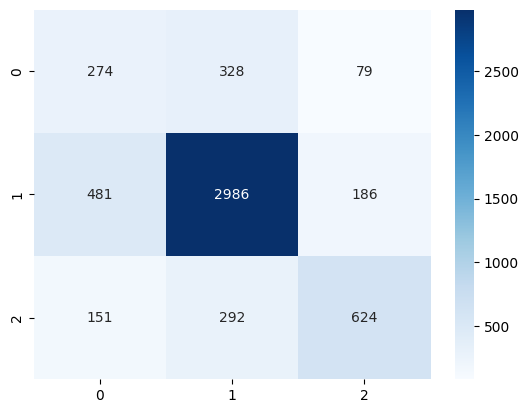

In [14]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
print('\n'+'effB1'+'\n-----------------')  
model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/BIRADS_EFFB1/best_model_0.7276acc_50epochs.h5')
phase='val'
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders[phase])
f1=f1_score(predictions,actuals,average=None)
recall=recall_score(actuals,predictions,average=None)
precision=precision_score(actuals,predictions,average=None)
print(f'F1 Score: {f1[0]} {f1[1]} {f1[2]} ')
print(f'Recall: {recall[0]} {recall[1]} {recall[2]}') 
print(f'Precision: {precision[0]} {precision[1]} {precision[2]} ')
print('\n')
get_metric.get_classification_report(actuals, predictions)
get_metric.test_model(model_ft,device,dataloaders[phase])
get_metric.get_cohen_kappa(actuals, predictions)
print('\n')
get_metric.get_confusion_matrix(actuals, predictions)
print('\n')
#get_metric.get_roc_curves(model_ft, device,  dataloaders[phase])